In [129]:
#分子構造ー理由ー融点データセットから物性予測

In [130]:
import glob
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(0)



# LLMで生成したデータセットの読み込みとクリーニング

In [131]:
json_dir="dataset/231225AutoReasoning/"

json_path_list=glob.glob(json_dir+"*.json")

def load_json(path):
    with open(path,"r") as f:
        d=json.load(f)

    return d

def select_best_reason_record(data):
    min_error = float('inf')
    min_error_dict = None

    for item in data:
        # Prediction(integer)がNoneでないアイテムだけを考慮
        if 'Prediction(integer)' in item:
            # 絶対誤差の計算
            error = abs(item['mpC'] - item['Prediction(integer)'])
            item["Abs error"]=error
            # 最小誤差を更新
            if error < min_error:
                min_error = error
                min_error_dict = item

    return min_error_dict



In [132]:
record_list=[]
for path in json_path_list:
    explanation_records=load_json(path)
    best_record=select_best_reason_record(explanation_records)
    record_list.append(best_record)

In [133]:
record_list=[i for i in record_list if i is not None]

In [134]:
df=pd.DataFrame(record_list)
cols=[ 'name', 'smiles', 'csid', 'link', 'source', 'Reason','mpC',
       'Prediction(integer)',"Abs error" ]
df=df[cols]
df=df[df["Abs error"]<=10]
df.shape
#df.to_csv(json_dir+"best_reason_record.csv",index=False)

(383, 9)

<Axes: xlabel='mpC', ylabel='Prediction(integer)'>

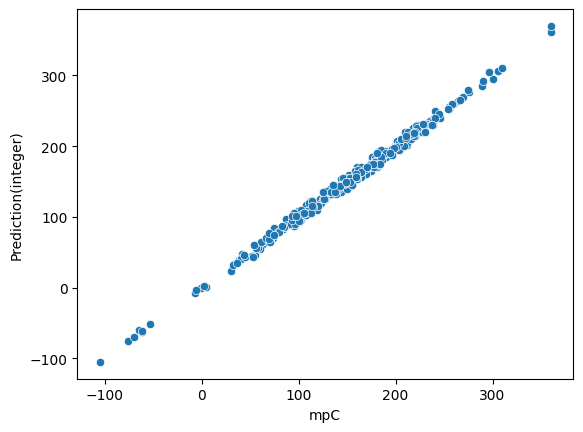

In [135]:
#訓練データのプロット
sns.scatterplot(data=df,x="mpC",y="Prediction(integer)")

# プロンプトチューニングによる予測

In [136]:
import openai

system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction="",prefix="Example"):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#{prefix} Data
##Name: {name}
##SMILES: {smiles} 
##Reason: {reason}
##Prediction: {prediction}
"""
    return prompt


#ask gpt
def json_generate(prompt,model="gpt-3.5-turbo-1106"):
    response = openai.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "system",
            "content": system_prompt,
        },
        {
            "role": "user",
            "content": f"""{prompt}"""
        }  
    ],
    response_format={ "type": "json_object" }
    )

    return (json.loads(response.choices[0].message.content))


#parse prediction
def prediction_string_to_number(prompt,model="gpt-3.5-turbo-1106"):
    response = openai.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "system",
            "content": """Extract integer from prediction. Use average if multiple numbers are included.
            Examples:
            In: 70.2 - 75.2 degrees Celsius
            Out: 73
            In: 75.2 degrees Celsius
            Out: 73
            In: For 1-naphthalenecarboxaldehyde, starting with the base value for naphthalene with a melting point of 80\u00b0C and subtracting the estimated aldehyde effect of approximately -47 to -50\u00b0C, the predicted melting point would be in the range of 30-33\u00b0C.
            Out: 32
            """,
        },
        {
            "role": "user",
            "content": f"""{prompt}
"#Output (JSON keys)
- Prediction"""
        }  
    ],
    response_format={ "type": "json_object" }
    )

    return (json.loads(response.choices[0].message.content))

#parse prediction
def prediction_string_to_number(prompt,model="gpt-3.5-turbo-1106"):
    response = openai.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "system",
            "content": """Extract integer from prediction. Use average if multiple numbers are included.
            Examples:
            In: 70.2 - 75.2 degrees Celsius
            Out: 73
            In: 75.2 degrees Celsius
            Out: 73
            In: For 1-naphthalenecarboxaldehyde, starting with the base value for naphthalene with a melting point of 80\u00b0C and subtracting the estimated aldehyde effect of approximately -47 to -50\u00b0C, the predicted melting point would be in the range of 30-33\u00b0C.
            Out: 32
            """,
        },
        {
            "role": "user",
            "content": f"""{prompt}
"#Output (JSON keys)
- Prediction"""
        }  
    ],
    response_format={ "type": "json_object" }
    )

    return (json.loads(response.choices[0].message.content))

In [137]:
dataset=df.to_dict(orient="records")


def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id],prefix="Test")
    prompt+="""
    #Output (JSON keys): Reason, Prediction
    """

    return prompt

In [138]:

model="gpt-4-1106-preview"
model="gpt-3.5-turbo-1106"

In [139]:
import copy
prediction_results={}


#do prediction with prompt tuning

n_problems=10
for n_prompt_examples in [0,1,5,10]:
    res_list=[]
    for test_id in range(n_problems):
        try:
            prompt=generate_question_prompt(dataset,test_id)
            r=json_generate(prompt,model=model)
            record=copy.deepcopy(dataset[test_id])

            record["Test (Predicted reason)"]=r["Reason"]
            record["Test (Predicted value)"]=prediction_string_to_number(r["Prediction"])["Prediction"]
            res_list.append(record)
            print(record)
        except Exception as e:
            print(e)
            continue

    prediction_results[n_prompt_examples]=res_list

    #break

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-1106-preview in organization org-h0H2pOz1ctmbW3hDvQ6YW03F on tokens_usage_based per day: Limit 500000, Used 499902, Requested 1956. Please try again in 5m21.062s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}
Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-1106-preview in organization org-h0H2pOz1ctmbW3hDvQ6YW03F on tokens_usage_based per day: Limit 500000, Used 499882, Requested 1628. Please try again in 4m20.928s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


KeyboardInterrupt: 

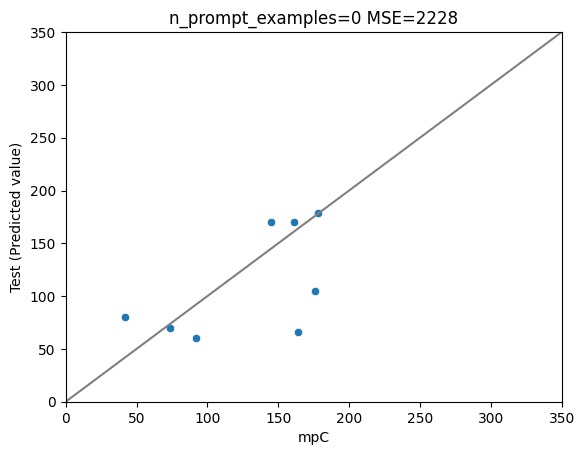

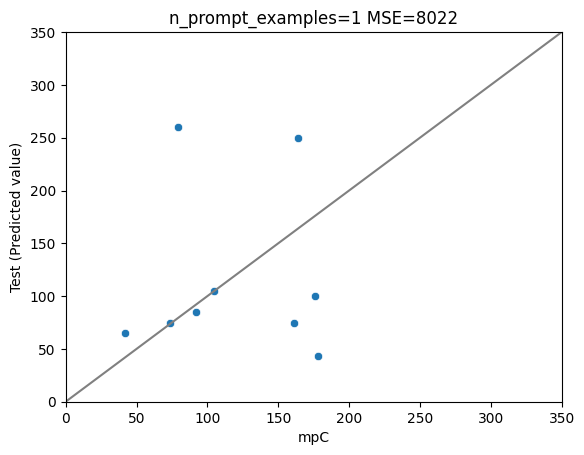

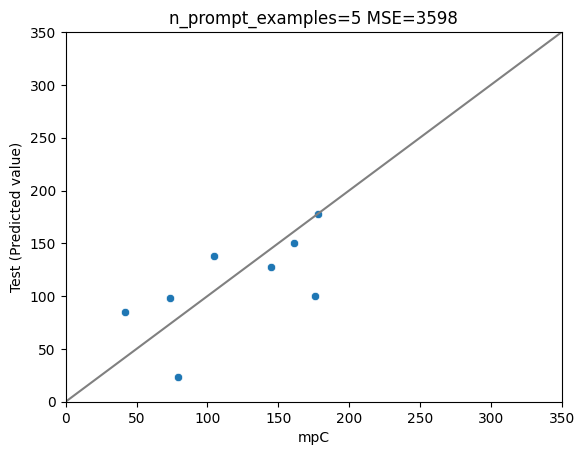

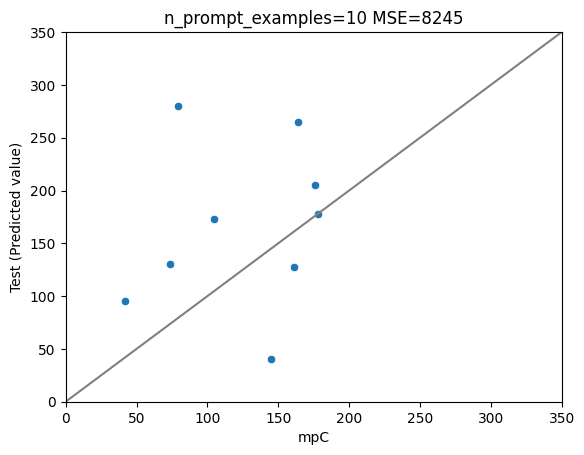

In [ ]:
from sklearn.metrics import mean_squared_error

vmin=0
vmax=350

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    #break

In [ ]:
with open(f"results/231226_PromptTuningPrediction_ijpynb_{model}.json","w") as f:
    json.dump(prediction_results,f,indent=4)